# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [368]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import models
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils.vis_utils import model_to_dot
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from IPython.display import SVG
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### 1. Data Exploration (Portfolio Data)

In [369]:
#Printing top5 rows from portfolio data
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [370]:
#Printing number of rows and columns in portfolio dataframe
print("portfolio data: Rows = {0}, Columns = {1}".format(str(portfolio.shape[0]), str(portfolio.shape[1])))

portfolio data: Rows = 10, Columns = 6


In [371]:
#Showing details in form of quantile, max, min , mean, standard deviation etc
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [372]:
#Printing datatype info about attributes of portfolio dataset
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [373]:
# Checking the null values
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [374]:
# Exploring different attributes under channel column in portfolio dataset
portfolio.channels

0         [email, mobile, social]
1    [web, email, mobile, social]
2            [web, email, mobile]
3            [web, email, mobile]
4                    [web, email]
5    [web, email, mobile, social]
6    [web, email, mobile, social]
7         [email, mobile, social]
8    [web, email, mobile, social]
9            [web, email, mobile]
Name: channels, dtype: object

#### 1.1 Portfolio Data Cleaning

In [375]:
# First of all we need to separate the values of channels attribute and create separate table for values of channels 
# I will apply the concept of dummy columns, I will rename the column "id" as "offer_id", as its part of portfolio's offer.
"""
.apply(pd.Series) converts the series of lists to a dataframe
.stack() puts everything in one column again (creating a multi-level index)
pd.get_dummies( ) creating the dummies
.sum(level=0) for remerging the different rows that should be one row (by summing up the second level, only keeping the original level (level=0))
"""
df1= portfolio.copy()

dummy = pd.get_dummies(df1.channels.apply(pd.Series).stack()).sum(level=0)
df1 = pd.concat([df1, dummy], axis=1)
df1 = df1.drop(columns='channels')
df1 = df1.rename(columns={'id':'offer_id'})
df1.head()


,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


### 2.Data Exploration (Profile Data)

In [376]:
# Printing top5 rows of profile data
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [377]:
#Row and Column detail about profile data
profile.shape

(17000, 5)

In [378]:
#Quantile, min, max etc info about profile data
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [379]:
profile.describe(include="all")

,age,became_member_on,gender,id,income
count,17000.000000,1.700000e+04,14825,17000,14825.000000
unique,NaN,NaN,3,17000,NaN
top,NaN,NaN,M,e6e82c8a1fdc47a3b3ce99bd74d9c937,NaN
freq,NaN,NaN,8484,1,NaN
mean,62.531412,2.016703e+07,NaN,NaN,65404.991568
std,26.738580,1.167750e+04,NaN,NaN,21598.299410
min,18.000000,2.013073e+07,NaN,NaN,30000.000000
25%,45.000000,2.016053e+07,NaN,NaN,49000.000000
50%,58.000000,2.017080e+07,NaN,NaN,64000.000000
75%,73.000000,2.017123e+07,NaN,NaN,80000.000000


In [380]:
# Printing all values under age attribute of profile dataset
profile['age'].unique()

array([118,  55,  75,  68,  65,  58,  61,  26,  62,  49,  57,  40,  64,
        78,  42,  56,  33,  46,  59,  67,  53,  22,  96,  69,  20,  45,
        54,  39,  41,  79,  66,  29,  44,  63,  36,  76,  77,  30,  51,
        27,  73,  74,  70,  89,  50,  90,  60,  19,  72,  52,  18,  71,
        83,  43,  47,  32,  38,  34,  85,  48,  35,  82,  21,  24,  81,
        25,  37,  23, 100,  28,  84,  80,  87,  86,  94,  31,  88,  95,
        93,  91,  92,  98, 101,  97,  99])

In [381]:
# Datatype information of profile attributes
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [382]:
# Checking the null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

#### 2.1 Profile data cleaning

In [383]:
# Checking the type of became_member_on attribute, as it contains value in the format of yy/mm/dd
type(profile.became_member_on[0])

numpy.int64

In [384]:
# Creating copy of dataframe for further implementaion, we need to change the type of "became_member_on" attribute 
# We will change the column name "id" to "customer_id"
df2 = profile.copy()

df2['became_member_on'] = pd.to_datetime(df2['became_member_on'], format='%Y%m%d')

df2 = df2.rename(columns={'id':'customer_id'})
df2.head(15)


,age,became_member_on,gender,customer_id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,2017-09-25,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,2017-10-02,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,2016-11-22,None,8974fc5686fe429db53ddde067b88302,NaN


#####  From above it looks like, that all null values belong to "age=118"

In [385]:
# Checking the above fact
df2[df2['age']== 118].drop(['became_member_on', 'customer_id'], axis=1)

,age,gender,income
0,118,None,NaN
2,118,None,NaN
4,118,None,NaN
6,118,None,NaN
7,118,None,NaN
9,118,None,NaN
10,118,None,NaN
11,118,None,NaN
17,118,None,NaN
23,118,None,NaN


In [386]:
# Cross checking the type of "became_member_on" attribute
type(df2.became_member_on[0])

pandas._libs.tslibs.timestamps.Timestamp

### 3. Data Exploration (Transcript Data)

In [387]:
# Print the transcript data 
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [388]:
# Printing rows and columns of transcript.json file
transcript.shape

(306534, 4)

In [ ]:
# Printing quantile, mean, max,min etc about transcript file
transcript.describe(include="all")

In [ ]:
# Displaying information about data type of transcript attributes
transcript.info()

In [ ]:
# Displaying the type of value and number of values against offer id
transcript['value'].value_counts()

In [ ]:
# Displaying the type of event and number of those event
transcript['event'].value_counts()

In [ ]:
# Checking the null value. if it is present in transcript data set
transcript.isnull().sum()

#### 3.1 Cleaning Transcript Data

In [394]:
"""
First we will create another copy of transcript dataset like profile and portfolio.
Will chnage the column name 'person' to 'customer_id'
Convert the column 'event' into 4 different columns, based on their types. Will apply the concept of dummy.

"""
df3 = transcript.copy()

df3['event'] = df3['event'].str.replace(' ', '-')

df3 = df3.rename(columns={'person':'customer_id'})
dummy = pd.get_dummies(df3['event'])
df3 = pd.concat([df3, dummy], axis=1 )
df3.head()


,event,customer_id,time,value,offer-completed,offer-received,offer-viewed,transaction
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,offer-received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,offer-received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,offer-received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,offer-received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [395]:
# This code is picked from https://stackoverflow.com/questions/60106364/syntaxerror-invalid-syntax-when-using-lambda-function-in-pandas-apply
df3['offer_id'] = [[*i.values()][0]if [*i.keys()][0] in ['offer id','offer_id'] else None for i in df3.value]
df3['amount'] = [np.round([*i.values()][0], decimals=2)if [*i.keys()][0] == 'amount' else None for i in df3.value]

In [ ]:
# Dropping the value column 
df3 = df3.drop(columns='value')
df3.head()

### Now We are done with data exploration and cleaning for all three datasets. Now as per need we will combine the data from all three datasets and draw visualization.

### Based on common attributes of all three datasets, we will try to merge the datasets.

In [397]:
# First will start to merge transcript and profile data on 'cutomer id'
df_merge= pd.merge(df3, df2, on='customer_id')
df_merge.head()

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,became_member_on,gender,income
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,None,19.89,75,2017-05-09,F,100000.0
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,None,17.78,75,2017-05-09,F,100000.0


In [398]:
# Merge the portfolio dataset with df_merge dataframe
df = pd.merge(df_merge, df1, on='offer_id', how='left')
df

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,...,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,None,19.89,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,None,17.78,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,offer-received,78afa995795e4d85b5d9ceeca43f5fef,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,NaN,75,...,F,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
6,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,216,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,NaN,75,...,F,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,0,0,0,1,None,19.67,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,0,0,0,1,None,29.72,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,0,0,0,1,None,23.93,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [399]:
df.columns

Index(['event', 'customer_id', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'age',
       'became_member_on', 'gender', 'income', 'difficulty', 'duration',
       'offer_type', 'reward', 'email', 'mobile', 'social', 'web'],
      dtype='object')

In [400]:
# Lets try some graph based on the findings of so far, before that lets find mean value
df['income'].mean()

64337.000755237168

In [401]:
type(df['time'])

pandas.core.series.Series

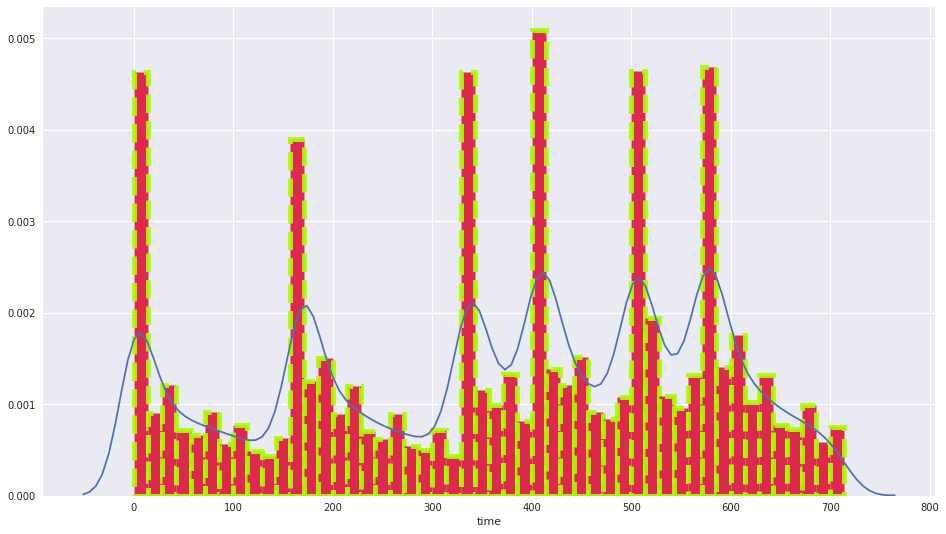

In [402]:
# distplot plot based on time attribute 
# This code is picked from https://indianaiproduction.com/seaborn-histogram-using-seaborn-distplot/
"""
Time attribute is related to offer_id, customer_id and other important attributes directly, so its 
important here to check maximum number of offers provided for particular category, as of now I am not 
defining 'time' attribute with respect to other attribute. I am just considering 'time' attribute alone.
"""
plt.figure(figsize=(16,9))
sns.set()
 
# hist keyword argument to change hist format
sns.distplot(df["time"],
            hist_kws = {'color':'#DC143C', 'edgecolor':'#aaff00',
                       'linewidth':5, 'linestyle':'--', 'alpha':0.9})

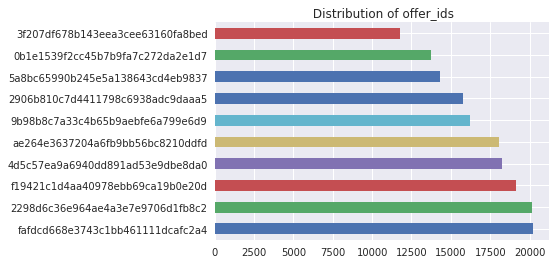

In [403]:
df['offer_id'].value_counts().plot.barh(title=' Distribution of offer_ids')


In [404]:
#Number of rows and columns in df dataframe
df.shape

(306534, 21)

In [405]:
# Detailed information about df dataframe in terms of quantile, mean, deviation, min, max etc
df.describe(include='all')

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,...,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
count,306534,306534,306534.000000,306534.000000,306534.000000,306534.000000,306534.000000,167581,138953.000000,306534.000000,...,272762,272762.000000,167581.000000,167581.000000,167581,167581.00000,167581.0,167581.000000,167581.000000,167581.000000
unique,4,17000,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,...,3,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN
top,transaction,94de646f7b6041228ca7dec82adb97d2,NaN,NaN,NaN,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,...,M,NaN,NaN,NaN,bogo,NaN,NaN,NaN,NaN,NaN
freq,138953,51,NaN,NaN,NaN,NaN,NaN,20241,NaN,NaN,...,155690,NaN,NaN,NaN,71617,NaN,NaN,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,366.382940,0.109544,0.248837,0.188315,0.453304,NaN,12.777356,60.909367,...,NaN,64337.000755,7.850401,6.610737,NaN,4.41991,1.0,0.917944,0.656996,0.806858
std,NaN,NaN,200.326314,0.312321,0.432340,0.390964,0.497815,NaN,30.250529,26.032030,...,NaN,21243.762941,5.048944,2.136130,NaN,3.37336,0.0,0.274451,0.474714,0.394765
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.050000,18.000000,...,NaN,30000.000000,0.000000,3.000000,NaN,0.00000,1.0,0.000000,0.000000,0.000000
25%,NaN,NaN,186.000000,0.000000,0.000000,0.000000,0.000000,NaN,2.780000,43.000000,...,NaN,48000.000000,5.000000,5.000000,NaN,2.00000,1.0,1.000000,0.000000,1.000000


In [406]:
#Data type information about the attributes of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 21 columns):
event               306534 non-null object
customer_id         306534 non-null object
time                306534 non-null int64
offer-completed     306534 non-null uint8
offer-received      306534 non-null uint8
offer-viewed        306534 non-null uint8
transaction         306534 non-null uint8
offer_id            167581 non-null object
amount              138953 non-null float64
age                 306534 non-null int64
became_member_on    306534 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
difficulty          167581 non-null float64
duration            167581 non-null float64
offer_type          167581 non-null object
reward              167581 non-null float64
email               167581 non-null float64
mobile              167581 non-null float64
social              167581 non-null float64
web                

In [407]:
df['offer_id'].nunique()

10

In [408]:
# Find all unique values of offer_id
offer_id = df['offer_id'].unique()
offer_id

array(['9b98b8c7a33c4b65b9aebfe6a799e6d9', None,
       '5a8bc65990b245e5a138643cd4eb9837',
       'ae264e3637204a6fb9bb56bc8210ddfd',
       'f19421c1d4aa40978ebb69ca19b0e20d',
       '0b1e1539f2cc45b7b9fa7c272da2e1d7',
       '3f207df678b143eea3cee63160fa8bed',
       '2906b810c7d4411798c6938adc9daaa5',
       'fafdcd668e3743c1bb461111dcafc2a4',
       '4d5c57ea9a6940dd891ad53e9dbe8da0',
       '2298d6c36e964ae4a3e7e9706d1fb8c2'], dtype=object)

In [409]:
# Convert the offer_id values into dictionary form
offer_dict = pd.Series(offer_id ).to_dict()
offer_dict

{0: '9b98b8c7a33c4b65b9aebfe6a799e6d9',
 1: None,
 2: '5a8bc65990b245e5a138643cd4eb9837',
 3: 'ae264e3637204a6fb9bb56bc8210ddfd',
 4: 'f19421c1d4aa40978ebb69ca19b0e20d',
 5: '0b1e1539f2cc45b7b9fa7c272da2e1d7',
 6: '3f207df678b143eea3cee63160fa8bed',
 7: '2906b810c7d4411798c6938adc9daaa5',
 8: 'fafdcd668e3743c1bb461111dcafc2a4',
 9: '4d5c57ea9a6940dd891ad53e9dbe8da0',
 10: '2298d6c36e964ae4a3e7e9706d1fb8c2'}

In [410]:
offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
offer_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 None: 1,
 '5a8bc65990b245e5a138643cd4eb9837': 2,
 'ae264e3637204a6fb9bb56bc8210ddfd': 3,
 'f19421c1d4aa40978ebb69ca19b0e20d': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '3f207df678b143eea3cee63160fa8bed': 6,
 '2906b810c7d4411798c6938adc9daaa5': 7,
 'fafdcd668e3743c1bb461111dcafc2a4': 8,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 9,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 10}

In [411]:
# mapping the offer_id with offer_dict, in order to get  
df['offer_id'] = df['offer_id'].map(offer_dict)
df

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,...,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0,NaN,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0,NaN,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,1,19.89,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0,NaN,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,1,17.78,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,offer-received,78afa995795e4d85b5d9ceeca43f5fef,168,0,1,0,0,2,NaN,75,...,F,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
6,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,216,0,0,1,0,2,NaN,75,...,F,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,0,0,0,1,1,19.67,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,0,0,0,1,1,29.72,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,0,0,0,1,1,23.93,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [412]:
df['offer_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [413]:
event_id = df['event'].unique()
event_id

array(['offer-received', 'offer-viewed', 'transaction', 'offer-completed'], dtype=object)

In [414]:
#in order to make compare and visualize all factors related to company promotions, like offers, event, we need to create co relation 
# between all factors, so that we can create more clear visualization. Here I am creating separate column, called event_id
# which is mapped according to event attribute.
event_dict = pd.Series(event_id).to_dict()

event_dict = dict([(value, key) for key, value in event_dict.items()]) 
df['event_id'] = df['event'].map(event_dict)
df

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,...,income,difficulty,duration,offer_type,reward,email,mobile,social,web,event_id
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0,NaN,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0,NaN,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,1,19.89,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0,NaN,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,1,17.78,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
5,offer-received,78afa995795e4d85b5d9ceeca43f5fef,168,0,1,0,0,2,NaN,75,...,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,0
6,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,216,0,0,1,0,2,NaN,75,...,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,1
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,0,0,0,1,1,19.67,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,0,0,0,1,1,29.72,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
9,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,0,0,0,1,1,23.93,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [415]:
# Lets cross check structure of dataframe
df.shape

(306534, 22)

In [416]:
#converting the dataframe into csv data
df.to_csv('data/data.csv', index=False)


In [417]:
data = pd.read_csv('data/data.csv')
data

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,...,income,difficulty,duration,offer_type,reward,email,mobile,social,web,event_id
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0,NaN,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0,NaN,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,1,19.89,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0,NaN,75,...,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,1,17.78,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
5,offer-received,78afa995795e4d85b5d9ceeca43f5fef,168,0,1,0,0,2,NaN,75,...,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,0
6,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,216,0,0,1,0,2,NaN,75,...,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,1
7,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,0,0,0,1,1,19.67,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
8,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,0,0,0,1,1,29.72,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
9,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,0,0,0,1,1,23.93,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [418]:
# Exploring data file
data.columns

Index(['event', 'customer_id', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'age',
       'became_member_on', 'gender', 'income', 'difficulty', 'duration',
       'offer_type', 'reward', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [419]:
data.gender.unique()

array(['F', nan, 'M', 'O'], dtype=object)

In [420]:
data.age.describe()

count    306534.000000
mean         60.909367
std          26.032030
min          18.000000
25%          43.000000
50%          57.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

## 4. Visualization of cleaned data

In [421]:
def horizontal_bar_plot(data, colName, pltTitle, pltfigsize=[5,5], bInvertYAxis=True, fntSize=12, fntWeight='bold'):
    """
    Creates a horizontal bar plot with counts of categories
    
    Parameters
    ----------
    df: The dataframe with categories.
    colName: The name of the column containing the categories.
    pltTitle: The plot title.
    pltfigsize: The figure size of the plot (default is [5,5]).
    bInvertYAxis: A flag to indicating whether to invert the Y-Axis or not.
    fntSize: The font size of text (default to 12 point font size)
    fntWeight: The weight of font (default to 'bold', it could be 'italic')
    
    Returns
    -------
    None
    """
    plt.figure(figsize=pltfigsize)
    fig, ax = plt.subplots()    
    y_counts = data[colName].value_counts()
    if bInvertYAxis == True:
        y_counts.plot(kind='barh').invert_yaxis()
    else:
         y_counts.plot(kind='barh')   
    for i, v in enumerate(y_counts):
        ax.text(v, i, str(v), color='black', fontsize=fntSize, fontweight=fntWeight)
        plt.title(pltTitle)

### Visualization #1

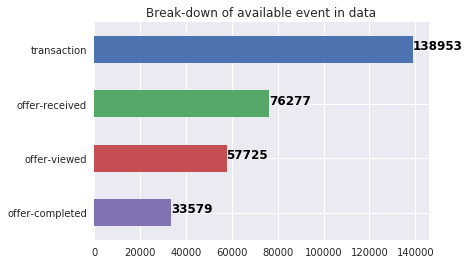

In [422]:
# Pulling number of event categories as per cleaned data
horizontal_bar_plot(data, 'event', "Break-down of available event in data")

#### Observation : From above graph it is clear that only approx half offers reach to audience and out of that only 1/3 offers are completed by customers. Many offers dont even get seen after receiving.  

### Visualization#2

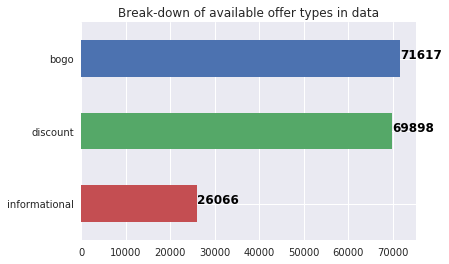

In [423]:
horizontal_bar_plot(data, 'offer_type', "Break-down of available offer types in data")

#### Observation: Bogo and discount offers have similar distributions, but Bogo comes on top. Thats why many patterns are coming based on Bogo in market.

### Visualization#3

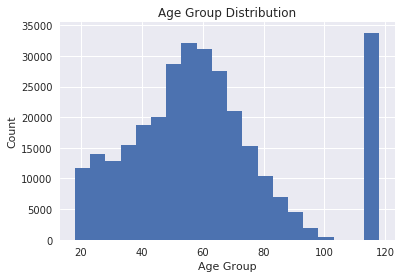

In [424]:
# Using histogram trying to pull outliers
data.age.hist(bins = 20, grid=True)
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution');

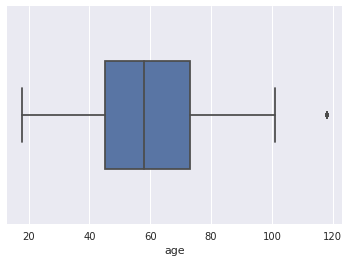

In [425]:
# Using box plot trying to pull outliers
sns.boxplot(profile['age'], width=0.5);

### Observation : 
##### Based on above two plots (histogram & Boxplot), we can see that age>100 is present , which is not possible. So will consider values above 
#### 100 as outlier. Age group between 47-62 use application the most. 63-71 age group uses the Starbuck app second most, as any
#### one may think here that younger age group must be using the app mostly. But this is not true here.

### Visualization#4

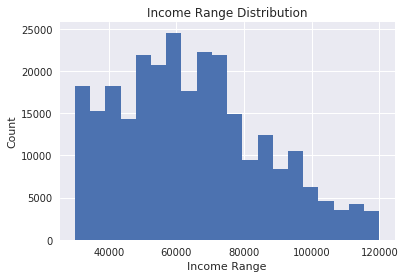

In [426]:
# Using histogram trying to pull outliers
data.income.hist(bins = 20, grid=True)
plt.xlabel('Income Range')
plt.ylabel('Count')
plt.title('Income Range Distribution');

#### Observation : Average income is 65000-74000

### Visualization#5

In [427]:
data['gender'].value_counts()

M    155690
F    113101
O      3971
Name: gender, dtype: int64

In [428]:
data['gender'].value_counts().sum()

272762

In [429]:
print("Male gender population  : {} % " .format(str(data.gender.value_counts()[0] / data.shape[0]*100)))
print("Female gender population  : {} % " .format(str(data.gender.value_counts()[1] / data.shape[0]*100)))
print("Other gender population  : {} %" .format(str(data.gender.value_counts()[2] / data.shape[0]*100)))

Male gender population  : 50.7904506515 % 
Female gender population  : 36.8967227127 % 
Other gender population  : 1.29545172803 %


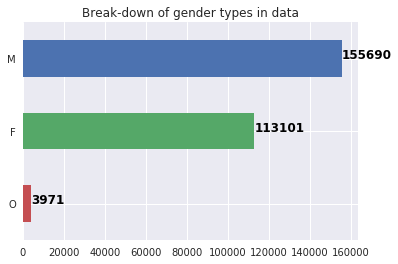

In [430]:
horizontal_bar_plot(data, 'gender', "Break-down of gender types in data")

#### Observation : Male is playing major role towards using Starbucks app

### Visualization#6

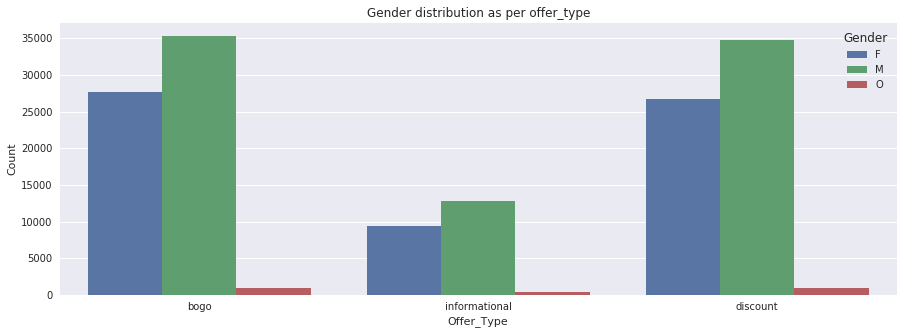

In [431]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "offer_type", hue= "gender", data=data)
sns.set(style="darkgrid")
plt.title('Gender distribution as per offer_type')
plt.ylabel('Count')
plt.xlabel('Offer_Type')
plt.xticks(rotation=0)
plt.legend(title='Gender')

#### Observation : As we can see here , that Male are using the all types of offers mostly. Informational type offer is close for male and female.

### Visualization# 7

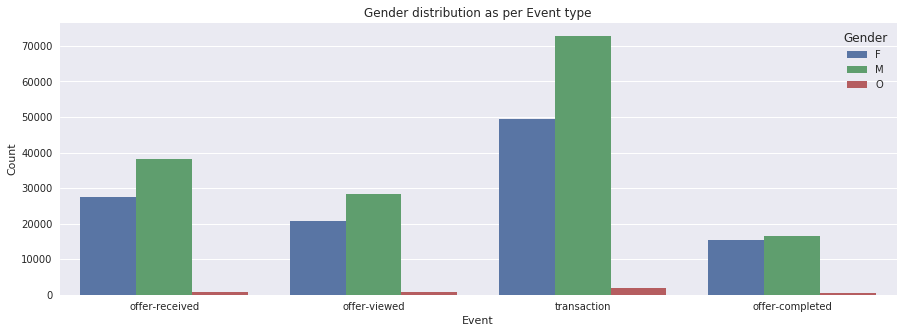

In [432]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "gender", data=data)
sns.set(style="darkgrid")
plt.title('Gender distribution as per Event type')
plt.ylabel('Count')
plt.xlabel('Event')
plt.xticks(rotation=0)
plt.legend(title='Gender')

#### Observation: Here are few intresting facts about event type disrtibution among the gender. As we can see that there is huge gap between offer-received and offer-completed. But under offer-completed event, male and female got almost same number of count. Which indicates that male usually ignores the offers mostly or dont pay attention towards it, whereas female pays more attention towards offer. Which seems to be correct in real life as well :)

### Visualization# 8

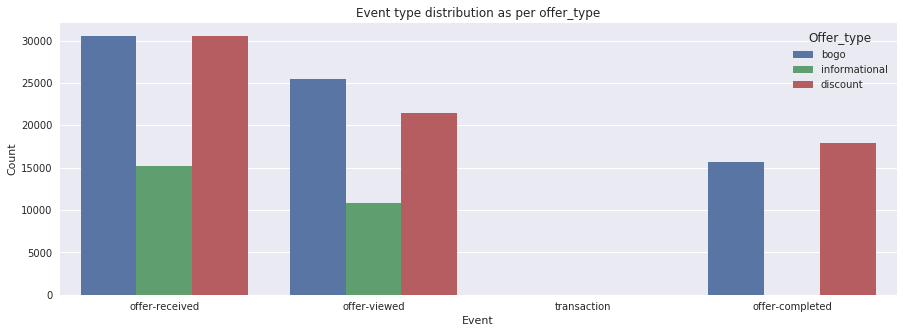

In [433]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "event", hue= "offer_type", data=data)
sns.set(style="whitegrid")
plt.title('Event type distribution as per offer_type')
plt.ylabel('Count')
plt.xlabel('Event')
plt.xticks(rotation=0)
plt.legend(title='Offer_type')

#### Observation : As we can see in above chart, that bogo and discount offers get receive in almost same quantity, but discount offers have less views compared to bogo offer, still discount offers are larger then bogo offer in terms of offer-completed category. 

### Visualization# 9

In [434]:
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()

 
print("Offer-Received as per types : {}".format(str(offer_received)))
print("Offer-Viewed as per types : {}".format(str(offer_viewed)))
print("Offer-Completed as per types : {}".format(str(offer_completed)))

Offer-Received as per types : 0     7677
5     7668
3     7658
10    7646
7     7632
2     7618
6     7617
8     7597
9     7593
4     7571
Name: offer_id, dtype: int64
Offer-Viewed as per types : 10    7337
8     7327
9     7298
4     7264
3     6716
2     6687
0     4171
6     4144
7     4118
5     2663
Name: offer_id, dtype: int64
Offer-Completed as per types : 8     5317
10    5156
0     4354
4     4296
7     4017
3     3688
5     3420
9     3331
Name: offer_id, dtype: int64


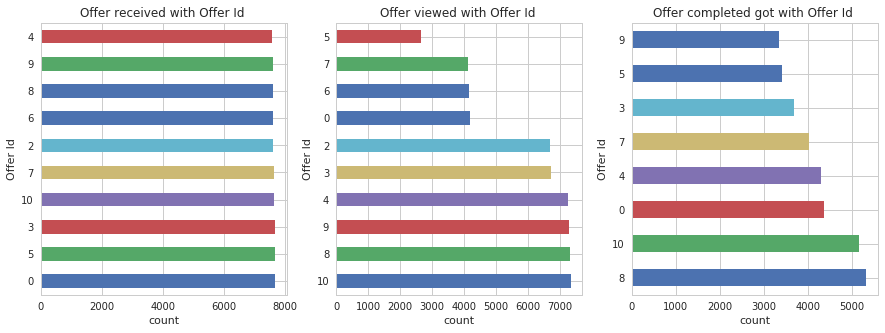

In [435]:
# Defining three subplots with grid size 1*3 for 1st subplot, with grid size 1*3 for 2nd subplot, with 1*3 grid size for 3rd subplot.
plt.subplot(1,3,1)
offer_received = data[data['offer-received'] == 1].offer_id.value_counts()
offer_received.plot(kind='barh', figsize=(15,5))
plt.ylabel('Offer Id')
plt.xlabel('count')
plt.title('Offer received with Offer Id ');

plt.subplot(1,3,2)
offer_viewed = data[data['offer-viewed'] == 1].offer_id.value_counts()
offer_viewed.plot(kind='barh' , figsize=(15,5))
plt.ylabel('Offer Id')
plt.xlabel('count')
plt.title('Offer viewed with Offer Id ');

plt.subplot(1,3,3)
offer_completed = data[data['offer-completed'] == 1].offer_id.value_counts()
offer_completed.plot(kind='barh' , figsize=(15,5))
plt.ylabel('Offer Id')
plt.xlabel('count')
plt.title('Offer completed got with Offer Id ');

#### Observation: From above subplots we can analyze that all Offer id received equal offers and 60% offer ids did view the offer in terms of good count, rest 40% is on average mark. If we talk about offer completion with respect to offer ids, then its showing considerably good count for all offer ids. 

### Visualization# 10

In [436]:
# Here I am pulling three platforms where offers get shoot up mostly, email, mobile and social platforms.
email_received = df1[df1['email'] == 1].offer_id.value_counts()
mobile_received = df1[df1['mobile'] == 1].offer_id.value_counts()
social_received = df1[df1['social'] == 1].offer_id.value_counts()

 
print("email-Received as per types : {}".format(str(email_received)))
print("mobile-Viewed as per types : {}".format(str(mobile_received)))
print("social-Completed as per types : {}".format(str(social_received)))

email-Received as per types : 2298d6c36e964ae4a3e7e9706d1fb8c2    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
f19421c1d4aa40978ebb69ca19b0e20d    1
5a8bc65990b245e5a138643cd4eb9837    1
2906b810c7d4411798c6938adc9daaa5    1
fafdcd668e3743c1bb461111dcafc2a4    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
3f207df678b143eea3cee63160fa8bed    1
0b1e1539f2cc45b7b9fa7c272da2e1d7    1
ae264e3637204a6fb9bb56bc8210ddfd    1
Name: offer_id, dtype: int64
mobile-Viewed as per types : fafdcd668e3743c1bb461111dcafc2a4    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
f19421c1d4aa40978ebb69ca19b0e20d    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
2906b810c7d4411798c6938adc9daaa5    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
3f207df678b143eea3cee63160fa8bed    1
5a8bc65990b245e5a138643cd4eb9837    1
ae264e3637204a6fb9bb56bc8210ddfd    1
Name: offer_id, dtype: int64
social-Completed as per types : 2298d6c36e964ae4a3e7e9706d1fb8c2    1
f19421c1d4aa40978ebb69ca19b0e20d    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
5a8bc65990b245e

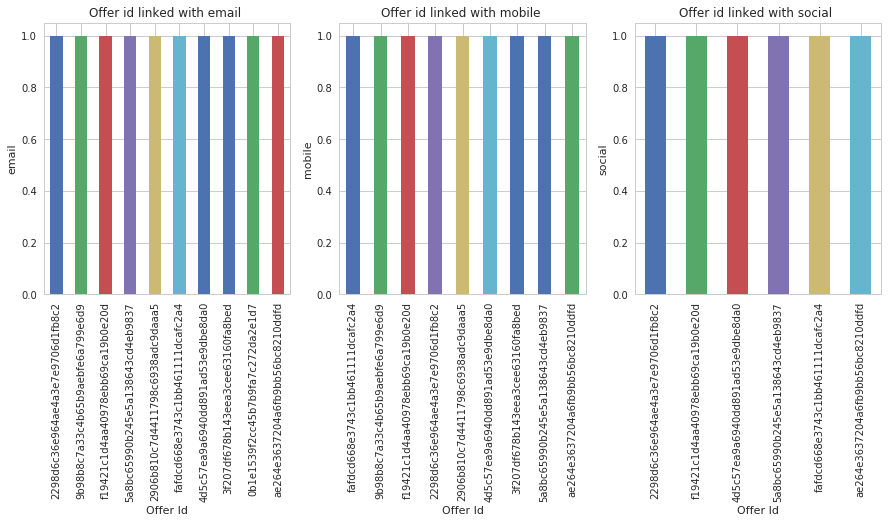

In [437]:
# Defining three subplots with grid size 1*3 for 1st subplot, with grid size 1*3 for 2nd subplot, with 1*3 grid size for 3rd subplot.
plt.subplot(1,3,1)
email = df1[df1['email'] == 1].offer_id.value_counts()
email.plot(kind='bar')
plt.ylabel('email')
plt.xlabel('Offer Id')
plt.title('Offer id linked with email ');

plt.subplot(1,3,2)
mobile = df1[df1['mobile'] == 1].offer_id.value_counts()
mobile.plot(kind='bar' , figsize=(15,5))
plt.ylabel('mobile')
plt.xlabel('Offer Id')
plt.title('Offer id linked with mobile ');

plt.subplot(1,3,3)
social = df1[df1['social'] == 1].offer_id.value_counts()
social.plot(kind='bar' , figsize=(15,5))
plt.ylabel('social')
plt.xlabel('Offer Id')
plt.title('Offer id linked with social ');

#### Observation : As we can see here offers get shoot up on email mostly. or can say first preference for Starbucks. Second its Mobile, and its also very popular medium for shooting offers. Mobile platform is almost equal to email. Social platform is bit low in terms of shooting offers, as its showing 60% compared to email. So may be Starbucks can consider to boost up the offers over social platform.

## 5. Build a Machine Learning model to predict response of a customer to the offer

##### Applying one hot encoding for gender and offer_type column, its the part of procedure to prepare the Pre Modal

In [438]:
# Classifying gender categories and mapping to existing gender categories
genders = {'O': 0, 'M': 1, 'F': 2}
data['gender'] = data['gender'].map(genders)

In [439]:
data.offer_type.value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

In [440]:
## Classifying offer_type categories and mapping to existing offer_type categories
offers = {'bogo': 0, 'discount': 1, 'informational': 2}
data['offer_type'] = data['offer_type'].map(offers)

In [441]:
data.head()

,event,customer_id,time,offer-completed,offer-received,offer-viewed,transaction,offer_id,amount,age,...,income,difficulty,duration,offer_type,reward,email,mobile,social,web,event_id
0,offer-received,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,0,NaN,75,...,100000.0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0,0
1,offer-viewed,78afa995795e4d85b5d9ceeca43f5fef,6,0,0,1,0,0,NaN,75,...,100000.0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0,1
2,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,0,0,0,1,1,19.89,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,offer-completed,78afa995795e4d85b5d9ceeca43f5fef,132,1,0,0,0,0,NaN,75,...,100000.0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0,3
4,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,0,0,0,1,1,17.78,75,...,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [442]:
# Inorder to create test and train variables for testing and training , we need to look into "data" dataframe again and arrange
# the columns as per need.
data.columns

Index(['event', 'customer_id', 'time', 'offer-completed', 'offer-received',
       'offer-viewed', 'transaction', 'offer_id', 'amount', 'age',
       'became_member_on', 'gender', 'income', 'difficulty', 'duration',
       'offer_type', 'reward', 'email', 'mobile', 'social', 'web', 'event_id'],
      dtype='object')

In [443]:
X = data.drop(['customer_id', 'event_id' , 'event' , 'became_member_on','offer-completed', 'offer-received','offer-viewed', 'transaction'], axis=1)
Y = data['event_id'] 

In [444]:
X.head()

,time,offer_id,amount,age,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,0,0,NaN,75,2.0,100000.0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0
1,6,0,NaN,75,2.0,100000.0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0
2,132,1,19.89,75,2.0,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132,0,NaN,75,2.0,100000.0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0
4,144,1,17.78,75,2.0,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [445]:
X['income'].mean()

64337.000755237168

In [446]:
X['income'].fillna(X['income'].mean(), inplace=True)

In [447]:
X['income'].isnull().sum()

0

In [448]:
X.head()

,time,offer_id,amount,age,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,0,0,NaN,75,2.0,100000.0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0
1,6,0,NaN,75,2.0,100000.0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0
2,132,1,19.89,75,2.0,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,132,0,NaN,75,2.0,100000.0,5.0,7.0,0.0,5.0,1.0,1.0,0.0,1.0
4,144,1,17.78,75,2.0,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [449]:
Y.head()

0    0
1    1
2    2
3    3
4    2
Name: event_id, dtype: int64

In [450]:
X.describe()

,time,offer_id,amount,age,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
count,306534.000000,306534.000000,138953.000000,306534.000000,272762.000000,306534.000000,167581.000000,167581.000000,167581.000000,167581.00000,167581.0,167581.000000,167581.000000,167581.000000
mean,366.382940,3.507862,12.777356,60.909367,1.400092,64337.000755,7.850401,6.610737,0.728185,4.41991,1.0,0.917944,0.656996,0.806858
std,200.326314,3.240048,30.250529,26.032030,0.518784,20039.365463,5.048944,2.136130,0.713456,3.37336,0.0,0.274451,0.474714,0.394765
min,0.000000,0.000000,0.050000,18.000000,0.000000,30000.000000,0.000000,3.000000,0.000000,0.00000,1.0,0.000000,0.000000,0.000000
25%,186.000000,1.000000,2.780000,43.000000,1.000000,50000.000000,5.000000,5.000000,0.000000,2.00000,1.0,1.000000,0.000000,1.000000
50%,408.000000,1.000000,8.890000,57.000000,1.000000,64337.000755,10.000000,7.000000,1.000000,5.00000,1.0,1.000000,1.000000,1.000000
75%,528.000000,6.000000,18.070000,72.000000,2.000000,75000.000000,10.000000,7.000000,1.000000,5.00000,1.0,1.000000,1.000000,1.000000
max,714.000000,10.000000,1062.280000,118.000000,2.000000,120000.000000,20.000000,10.000000,2.000000,10.00000,1.0,1.000000,1.000000,1.000000


In [451]:
Y.describe()

count    306534.000000
mean          1.423555
std           0.980266
min           0.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: event_id, dtype: float64

In [452]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 14 columns):
time          306534 non-null int64
offer_id      306534 non-null int64
amount        138953 non-null float64
age           306534 non-null int64
gender        272762 non-null float64
income        306534 non-null float64
difficulty    167581 non-null float64
duration      167581 non-null float64
offer_type    167581 non-null float64
reward        167581 non-null float64
email         167581 non-null float64
mobile        167581 non-null float64
social        167581 non-null float64
web           167581 non-null float64
dtypes: float64(11), int64(3)
memory usage: 32.7 MB


In [453]:
X.shape , Y.shape

((306534, 14), (306534,))

#### Feature Engineering 


In [454]:
class_name =['offer recieved', 'offer viewed', 'transaction', 'offer completed']

In [455]:
#split the dataset into test and train sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [456]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((214573, 14), (91961, 14), (214573,), (91961,))

In [457]:
std = StandardScaler()

In [458]:
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

In [459]:
X_train.income = std.fit_transform(X_train.income.values.reshape(-1, 1))
X_train.age = std.fit_transform(X_train.age.values.reshape(-1, 1))

X_train.reset_index(inplace=True)
X_train = X_train.drop(['index'], axis=1)

In [460]:
X_train.shape, X_test.shape

((214573, 14), (91961, 14))

In [461]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [462]:
y_train[0:1].shape

(1,)

#### Building the Modal

In [463]:
ann = keras.models.Sequential()

In [464]:
NUM_ROWS = 100
NUM_COLS = 100
ann.add(keras.layers.Dense(6, activation='relu', input_shape=(NUM_ROWS * NUM_COLS,)))
#ann.add(Dropout(0.5))
ann.add(keras.layers.Dense(6, activation='relu'))
#ann.add(Dropout(0.25))
ann.add(keras.layers.Dense(4, activation = 'softmax'))



In [465]:
ann.compile(optimizer = 'adam', 
            loss = 'sparse_categorical_crossentropy', 
            metrics = ['accuracy'])

In [466]:
ann_history = ann.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=100)
#plot_losses = livelossplot.PlotLossesKeras()

 

#ann.fit(X_train, y_train, epochs=15, batch_size=100, verbose=1)

#ann.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, callbacks=[], validation_split=0.0, validation_data=(X_test, y_test), shuffle=True, class_weight=None, sample_weight=None)


ValueError: Error when checking input: expected dense_16_input to have shape (None, 10000) but got array with shape (214573, 14)